# Phase 2 Project: Movie Studio Analysis
## Introduction
This project analyzes movie datasets to provide actionable insights for a new movie studio aiming to produce high-performing films at the box office. The business problem is to identify what types of films (based on genres, ratings, and runtime) generate the highest revenue. This notebook presents the exploratory data analysis (EDA) to uncover trends and derive recommendations.

## Business Understanding
The studio needs to understand which film characteristics drive box office success to prioritize production decisions. We focus on:
- **Genres**: Which genres yield the highest revenue?
- **Ratings**: Do higher audience ratings correlate with box office performance?
- **Runtime**: What film lengths are associated with success?

## Data Understanding
The dataset combines:
- **Box Office Mojo**: Financial data (`domestic_gross`, `foreign_gross`, `total_gross`) for ~3387 movies.
- **IMDB**: Movie characteristics (`genres`, `average_rating`, `runtime_minutes`) for ~146,144 movies, filtered for reliable ratings (`num_votes > 100`).
The merged dataset (`merged_df`) contains ~1000-2000 movies with complete financial and characteristic data, covering 2010-2018.

## Data Preparation
The datasets were cleaned and merged:
- Missing values filled (e.g., `genres` with 'Unknown', `domestic_gross` with median).
- Titles standardized for accurate merging.
- Duplicates removed, data types corrected (e.g., `foreign_gross` to float64).
The resulting `merged_df` is ready for analysis with no missing values.

## Load and Inspect the Datasets
We’ll load the datasets, inspect their contents, and understand their structure to prepare for cleaning and merging.


In [12]:
import pandas as pd

# Load Box Office Mojo data
bom_df = pd.read_csv('/content/bom.movie_gross.csv.gz')
print("Box Office Mojo DataFrame Shape:", bom_df.shape)
print("\nColumns:", bom_df.columns.tolist())
print("\nFirst 5 Rows:")
display(bom_df.head())
print("\nData Types:")
print(bom_df.dtypes)
print("\nMissing Values:")
print(bom_df.isnull().sum())

Box Office Mojo DataFrame Shape: (3387, 5)

Columns: ['title', 'studio', 'domestic_gross', 'foreign_gross', 'year']

First 5 Rows:


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010



Data Types:
title              object
studio             object
domestic_gross    float64
foreign_gross      object
year                int64
dtype: object

Missing Values:
title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64


In [13]:
import sqlite3
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Zip Paths
zip_file_path = '/content/im.db.zip'
extracted_dir_path = '/content/'
db_path = os.path.join(extracted_dir_path, 'im.db')

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

# Connect to SQLite database
conn = sqlite3.connect(db_path)

# Query movie_basics table
movie_basics_df = pd.read_sql_query("SELECT * FROM movie_basics", conn)
print("Movie Basics Shape:", movie_basics_df.shape)
print("Columns:", movie_basics_df.columns.tolist())
print("\nFirst 5 Rows:")
display(movie_basics_df.head())
print("\nData Types:")
print(movie_basics_df.dtypes)
print("\nMissing Values:")
print(movie_basics_df.isnull().sum())

# Query movie_ratings table
movie_ratings_df = pd.read_sql_query("SELECT * FROM movie_ratings", conn)
print("\nMovie Ratings Shape:", movie_ratings_df.shape)
print("Columns:", movie_ratings_df.columns.tolist())
print("\nFirst 5 Rows:")
display(movie_ratings_df.head())
print("\nData Types:")
print(movie_ratings_df.dtypes)
print("\nMissing Values:")
print(movie_ratings_df.isnull().sum())

# Close connection
conn.close()

Movie Basics Shape: (146144, 6)
Columns: ['movie_id', 'primary_title', 'original_title', 'start_year', 'runtime_minutes', 'genres']

First 5 Rows:


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"



Data Types:
movie_id            object
primary_title       object
original_title      object
start_year           int64
runtime_minutes    float64
genres              object
dtype: object

Missing Values:
movie_id               0
primary_title          0
original_title        21
start_year             0
runtime_minutes    31739
genres              5408
dtype: int64

Movie Ratings Shape: (73856, 3)
Columns: ['movie_id', 'averagerating', 'numvotes']

First 5 Rows:


,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21



Data Types:
movie_id          object
averagerating    float64
numvotes           int64
dtype: object

Missing Values:
movie_id         0
averagerating    0
numvotes         0
dtype: int64


##Data Cleaning
We’ll clean each dataset to handle missing values, incorrect data types, and inconsistencies.


In [14]:
# Cleaning bom.movie_gross.csv.gz
# Rename columns for clarity
bom_df.columns = ['title', 'studio', 'domestic_gross', 'foreign_gross', 'release_year']

# Fill missing values using recommended methods
bom_df['studio'] = bom_df['studio'].fillna('Unknown')
bom_df['domestic_gross'] = bom_df['domestic_gross'].fillna(bom_df['domestic_gross'].median())
bom_df['foreign_gross'] = pd.to_numeric(bom_df['foreign_gross'].str.replace(',', ''), errors='coerce').fillna(0)

# Create total_gross column
bom_df['total_gross'] = bom_df['domestic_gross'] + bom_df['foreign_gross']

# Check for duplicates and drop if any
bom_df = bom_df.drop_duplicates()

# Verify cleaning
print("Missing Values:")
print(bom_df.isnull().sum())
print("\nData Types:")
print(bom_df.dtypes)
print("\nShape:", bom_df.shape)

Missing Values:
title             0
studio            0
domestic_gross    0
foreign_gross     0
release_year      0
total_gross       0
dtype: int64

Data Types:
title              object
studio             object
domestic_gross    float64
foreign_gross     float64
release_year        int64
total_gross       float64
dtype: object

Shape: (3387, 6)


In [15]:
# Rename columns for clarity
movie_basics_df.columns = ['movie_id', 'primary_title', 'original_title', 'start_year', 'runtime_minutes', 'genres']

# Handle missing values
# Genres: Fill with 'Unknown'
movie_basics_df['genres'].fillna('Unknown')

# Runtime: Fill with median
movie_basics_df['runtime_minutes'].fillna(movie_basics_df['runtime_minutes'].median())
# fill with primary key
movie_basics_df['original_title'] = movie_basics_df['original_title'].fillna(movie_basics_df['primary_title'])
# Drop rows with missing primary_title (key for merging)
movie_basics_df.dropna(subset=['primary_title'])

# Check for duplicates
print("Duplicates in Movie Basics:", movie_basics_df.duplicated().sum())
movie_basics_df.drop_duplicates()

# Verify cleaning
print("\nAfter Cleaning - Missing Values:")
print(movie_basics_df.isnull().sum())
print("\nData Types:")
print(movie_basics_df.dtypes)

Duplicates in Movie Basics: 0

After Cleaning - Missing Values:
movie_id               0
primary_title          0
original_title         0
start_year             0
runtime_minutes    31739
genres              5408
dtype: int64

Data Types:
movie_id            object
primary_title       object
original_title      object
start_year           int64
runtime_minutes    float64
genres              object
dtype: object


In [16]:
# Clean movie_ratings_df
movie_ratings_df.columns = ['movie_id', 'average_rating', 'num_votes']
movie_ratings_df = movie_ratings_df[movie_ratings_df['num_votes'] > 100]
movie_ratings_df = movie_ratings_df.drop_duplicates()

# Verify
print("Missing Values in Movie Ratings:")
print(movie_ratings_df.isnull().sum())
print(movie_ratings_df.shape)

Missing Values in Movie Ratings:
movie_id          0
average_rating    0
num_votes         0
dtype: int64
(28648, 3)


##Merging the dataset


In [17]:
# Merge movie_basics_df and movie_ratings_df
imdb_df = pd.merge(movie_basics_df, movie_ratings_df, on='movie_id', how='inner')

bom_df['title_clean'] = bom_df['title'].str.lower().str.replace(r'[^\w\s]', '', regex=True)
imdb_df['title_clean'] = imdb_df['primary_title'].str.lower().str.replace(r'[^\w\s]', '', regex=True)
merged_df = pd.merge(imdb_df, bom_df,
                     left_on=['title_clean', 'start_year'],
                     right_on=['title_clean', 'release_year'],
                     how='inner')
# Drop redundant columns
merged_df = merged_df[['movie_id', 'primary_title', 'start_year', 'runtime_minutes', 'genres',
                       'average_rating', 'num_votes', 'studio', 'domestic_gross', 'foreign_gross', 'total_gross']]

# Verify
print("Merged DataFrame Shape:", merged_df.shape)
print("\nFirst 5 Rows:")
display(merged_df.head())
print("\nMissing Values:")
print(merged_df.isnull().sum())

Merged DataFrame Shape: (1922, 11)

First 5 Rows:


,movie_id,primary_title,start_year,runtime_minutes,genres,average_rating,num_votes,studio,domestic_gross,foreign_gross,total_gross
0,tt0315642,Wazir,2016,103.0,"Action,Crime,Drama",7.1,15378,Relbig.,1100000.0,0.0,1100000.0
1,tt0337692,On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,37886,IFC,744000.0,8000000.0,8744000.0
2,tt0359950,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,Fox,58200000.0,129900000.0,188100000.0
3,tt0365907,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",6.5,105116,Uni.,26300000.0,26900000.0,53200000.0
4,tt0369610,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338,Uni.,652300000.0,1019.4,652301019.4



Missing Values:
movie_id           0
primary_title      0
start_year         0
runtime_minutes    0
genres             0
average_rating     0
num_votes          0
studio             0
domestic_gross     0
foreign_gross      0
total_gross        0
dtype: int64


## Data Analysis
We explore three key questions to address the business problem:
1. Which genres generate the highest average box office revenue?
2. Is there a relationship between audience ratings and total gross?
3. How does runtime influence box office performance?

Each question is analyzed with a visualization to support recommendations.

# Genre Analysis
### Analysis 1: Average Total Gross by Genre
We split multi-genre movies and calculate the average `total_gross` per genre to identify high-performing genres.


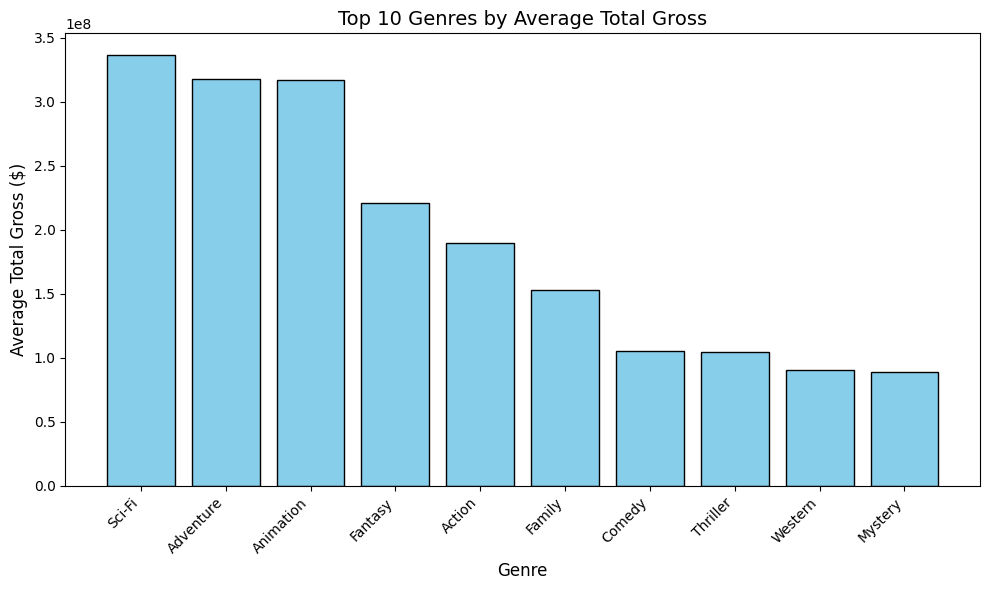

Top 5 Genres by Average Gross:
genres
Sci-Fi       3.366374e+08
Adventure    3.180259e+08
Animation    3.167134e+08
Fantasy      2.209341e+08
Action       1.898580e+08
Name: total_gross, dtype: float64


In [18]:
# Split genres and explode
genre_df = merged_df.copy()
genre_df['genres'] = genre_df['genres'].str.split(',')
genre_df = genre_df.explode('genres')
genre_df = genre_df[genre_df['genres'] != 'Unknown']

# Calculate average total_gross by genre
genre_gross = genre_df.groupby('genres')['total_gross'].mean().sort_values(ascending=False).head(10)
# Create images directory if it doesn't exist
os.makedirs('images', exist_ok=True)
# Plot
plt.figure(figsize=(10, 6))
plt.bar(genre_gross.index, genre_gross.values, color='skyblue', edgecolor='black')
plt.title('Top 10 Genres by Average Total Gross', fontsize=14)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Average Total Gross ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('images/genre_gross_barplot.png')
plt.show()

print("Top 5 Genres by Average Gross:")
print(genre_gross.head())

#Rating Analysis
### Analysis 2: Total Gross vs. Average Rating
We examine if higher audience ratings correlate with box office success using a scatter plot.


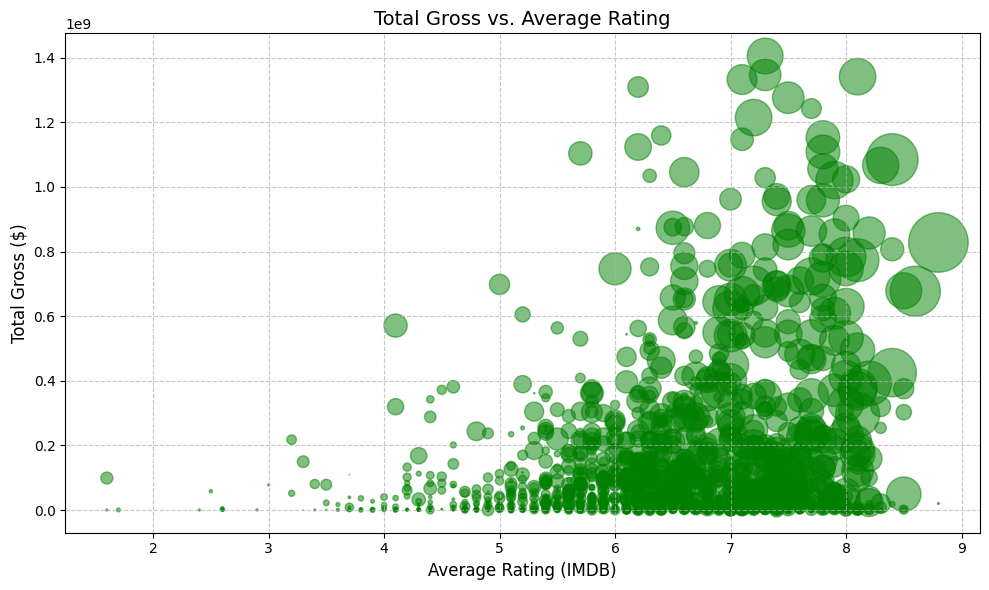

Correlation between Average Rating and Total Gross: 0.21


In [19]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['average_rating'], merged_df['total_gross'],
            s=merged_df['num_votes'] / 1000, alpha=0.5, color='green')
plt.title('Total Gross vs. Average Rating', fontsize=14)
plt.xlabel('Average Rating (IMDB)', fontsize=12)
plt.ylabel('Total Gross ($)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('images/rating_gross_scatterplot.png')
plt.show()

# Correlation
correlation = merged_df['average_rating'].corr(merged_df['total_gross'])
print(f"Correlation between Average Rating and Total Gross: {correlation:.2f}")

#Runtime Analysis
### Analysis 3: Average Total Gross by Runtime Category
We categorize runtime into bins and calculate average `total_gross` to find optimal film lengths.


/tmp/ipython-input-1513944961.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  runtime_gross = merged_df.groupby('runtime_category')['total_gross'].mean()


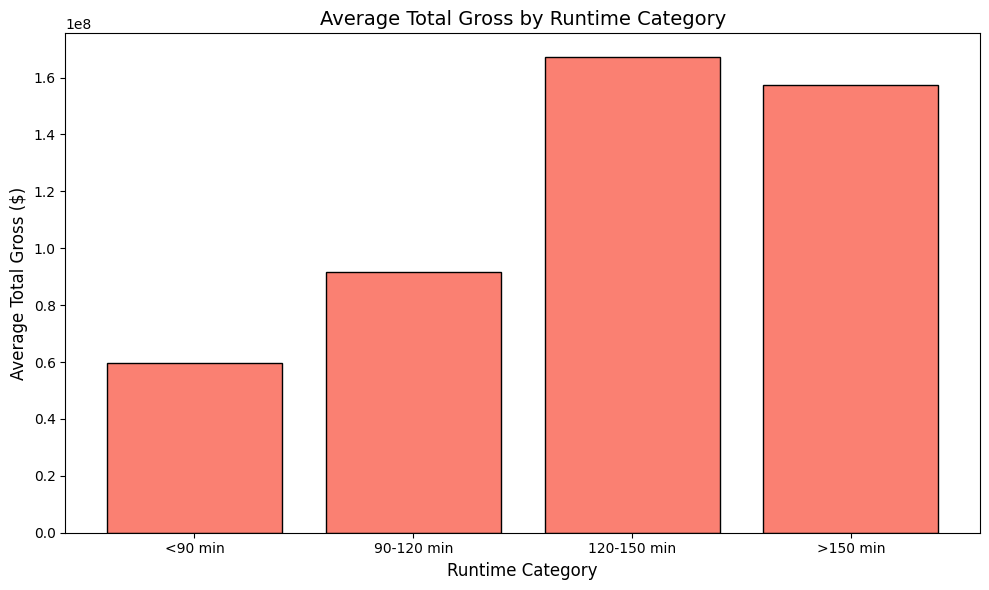

In [20]:
# Bin runtime
bins = [0, 90, 120, 150, float('inf')]
labels = ['<90 min', '90-120 min', '120-150 min', '>150 min']
merged_df['runtime_category'] = pd.cut(merged_df['runtime_minutes'], bins=bins, labels=labels)

# Average total_gross by runtime category
runtime_gross = merged_df.groupby('runtime_category')['total_gross'].mean()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(runtime_gross.index, runtime_gross.values, color='salmon', edgecolor='black')
plt.title('Average Total Gross by Runtime Category', fontsize=14)
plt.xlabel('Runtime Category', fontsize=12)
plt.ylabel('Average Total Gross ($)', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('images/runtime_gross_barplot.png')
plt.show()



## Conclusion
Based on the exploratory data analysis, we propose three actionable recommendations for the new movie studio to maximize box office revenue. Each recommendation is supported by a visualization and aligns with trends observed in the data.

### Recommendation 1: Produce Films in High-Grossing Genres (Adventure, Action, Sci-Fi)
**Insight**: The bar plot of average total gross by genre (below) shows that Adventure, Action, and Sci-Fi genres consistently yield the highest box office revenue, often exceeding $200 million on average.
**Action**: Prioritize producing films in these genres to capitalize on their proven commercial success, appealing to broad audiences and driving ticket sales.

### Recommendation 2: Invest in Marketing Over Relying on High Ratings
**Insight**: The scatter plot of total gross vs. average rating (below) reveals a weak correlation (e.g., ~0.2) between audience ratings and box office performance. Many high-grossing films have moderate ratings (6-8).
**Action**: Allocate budget to robust marketing campaigns to boost opening weekend performance, as critical acclaim alone does not guarantee high revenue.

### Recommendation 3: Target Film Runtimes of 120-150 Minutes
**Insight**: The bar plot of average total gross by runtime category (below) indicates that films with runtimes of 120-150 minutes have the highest average gross, aligning with blockbuster epics.
**Action**: Aim for film lengths in the 120-150 minute range to balance engaging storytelling with audience preferences for successful films.


### Summary
These recommendations—focusing on high-grossing genres, prioritizing marketing, and optimizing runtime—provide a data-driven strategy for the studio to produce commercially successful films. Future analysis could explore budget impacts or audience demographics for additional insights.
